In [1]:
import os

from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import scipy.optimize

import torch
from torch import nn
from torch.cuda.amp import autocast
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [3]:
def save_model(model, i):
    sd = model.state_dict()
    torch.save(model.state_dict(), '%s.pt' % i)

def load_model(model, i):
    sd = torch.load('%s.pt' % i)
    model.load_state_dict(sd)

## Load data & models

In [4]:
from ffcv.pipeline.operation import Operation
from ffcv.loader import Loader, OrderOption
from ffcv.transforms import ToTensor, ToDevice, Squeeze, NormalizeImage, \
    RandomHorizontalFlip, ToTorchImage
from ffcv.fields.rgb_image import CenterCropRGBImageDecoder, \
    RandomResizedCropRGBImageDecoder
from ffcv.fields.basics import IntDecoder

device = torch.device('cuda')
res = 224
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])
DEFAULT_CROP_RATIO = 224/256
denormalize = T.Normalize(-IMAGENET_MEAN/IMAGENET_STD, 1/IMAGENET_STD)

def get_loader(name, aug=False):
    dset_path = '/persist/kjordan/data_image/ffcv_imagenet/%s.ffcv' % name
    
    image_pipeline = (([
        RandomResizedCropRGBImageDecoder((res, res)),
        RandomHorizontalFlip(),
    ] if aug else [
        CenterCropRGBImageDecoder((res, res), ratio=DEFAULT_CROP_RATIO),
    ])+[
        ToTensor(),
        ToDevice(device, non_blocking=True),
        ToTorchImage(),
        NormalizeImage(IMAGENET_MEAN*255, IMAGENET_STD*255, np.float16),
    ])

    label_pipeline = [
        IntDecoder(),
        ToTensor(),
        Squeeze(),
        ToDevice(device, non_blocking=True)
    ]

    loader = Loader(dset_path,
                    batch_size=200,
                    num_workers=4,
                    order=OrderOption.SEQUENTIAL,
                    drop_last=False,
                    pipelines={
                        'image': image_pipeline,
                        'label': label_pipeline
                    },
                    distributed=False)
    return loader
    
# train50k_loader = get_loader('train50k')
# train50k_aug_loader = get_loader('train50k', aug=True)
train10k_aug_loader = get_loader('train10k', aug=True)
train10k_loader = get_loader('train10k')
train5k_loader = get_loader('train5k')

# train_loader = train10k_aug_loader
train_loader = train10k_loader

val_loader = val5k_loader = get_loader('val5k')

In [5]:
# evaluates accuracy
def evaluate(model, loader=val5k_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad(), autocast():
        for inputs, labels in loader:
            outputs = model(inputs.cuda())
            pred = outputs.argmax(dim=1)
            correct += (labels.cuda() == pred).sum().item()
            total += len(labels)
    return correct / total

# evaluates acc and loss
def evaluate2(model, loader=val5k_loader):
    model.eval()
    losses = []
    correct = 0
    total = 0
    with torch.no_grad(), autocast():
        for inputs, labels in loader:
            outputs = model(inputs.cuda())
            pred = outputs.argmax(dim=1)
            correct += (labels.cuda() == pred).sum().item()
            total += len(labels)
            loss = F.cross_entropy(outputs, labels.cuda())
            losses.append(loss.item())
    return correct / total, np.array(losses).mean()

def full_eval(model):
    tr_acc, tr_loss = evaluate2(model, loader=train5k_loader)
    te_acc, te_loss = evaluate2(model, loader=val5k_loader)
    return (100*tr_acc, tr_loss, 100*te_acc, te_loss)

865


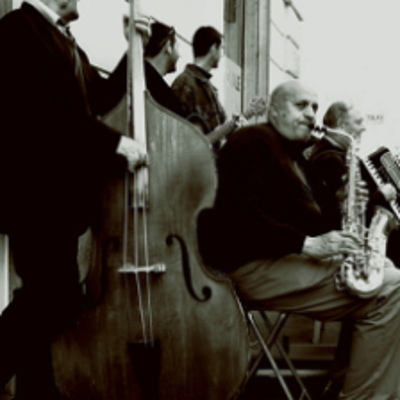

In [6]:
images, labels = next(iter(train5k_loader))
print(labels[1].item())

img_a = denormalize(images[0]).float()
img_a = img_a.permute(1, 2, 0)
img_a = img_a.cpu().numpy()
img_a = (255 * img_a).astype(np.uint8)
Image.fromarray(img_a).resize((400, 400))

In [7]:
def resnet18():
    model = torchvision.models.resnet18(pretrained=False)
    return model.cuda().eval()

def get_blocks(net):
    return nn.Sequential(nn.Sequential(net.conv1, net.bn1, net.relu, net.maxpool),
                         *net.layer1, *net.layer2, *net.layer3, *net.layer4)

def add_junctures(net):
    net1 = resnet18()
    net1.load_state_dict(net.state_dict())
    blocks = get_blocks(net1)[1:]
    for block in blocks:
        if block.downsample is not None:
            continue
        planes = len(block.bn2.weight)
        shortcut = nn.Conv2d(planes, planes, kernel_size=1, stride=1, padding=0, bias=False)
        shortcut.weight.data[:, :, 0, 0] = torch.eye(planes)
        block.downsample = shortcut
    return net1.cuda().eval()

### Matching code

In [8]:
# given two networks net0, net1 which each output a feature map of shape NxCxWxH
# this will reshape both outputs to (N*W*H)xC
# and then compute a CxC correlation matrix between the outputs of the two networks
def run_corr_matrix(net0, net1, epochs=1, loader=train_loader):
    n = epochs*len(loader)
    mean0 = mean1 = std0 = std1 = None
    with torch.no_grad():
        net0.eval()
        net1.eval()
        for _ in range(epochs):
            for i, (images, _) in enumerate(tqdm(loader)):
                img_t = images.float().cuda()
                out0 = net0(img_t)
                out0 = out0.reshape(out0.shape[0], out0.shape[1], -1).permute(0, 2, 1)
                out0 = out0.reshape(-1, out0.shape[2]).double()

                out1 = net1(img_t)
                out1 = out1.reshape(out1.shape[0], out1.shape[1], -1).permute(0, 2, 1)
                out1 = out1.reshape(-1, out1.shape[2]).double()

                mean0_b = out0.mean(dim=0)
                mean1_b = out1.mean(dim=0)
                std0_b = out0.std(dim=0)
                std1_b = out1.std(dim=0)
                outer_b = (out0.T @ out1) / out0.shape[0]

                if i == 0:
                    mean0 = torch.zeros_like(mean0_b)
                    mean1 = torch.zeros_like(mean1_b)
                    std0 = torch.zeros_like(std0_b)
                    std1 = torch.zeros_like(std1_b)
                    outer = torch.zeros_like(outer_b)
                mean0 += mean0_b / n
                mean1 += mean1_b / n
                std0 += std0_b / n
                std1 += std1_b / n
                outer += outer_b / n

    cov = outer - torch.outer(mean0, mean1)
    corr = cov / (torch.outer(std0, std1) + 1e-4)
    return corr

In [9]:
def get_layer_perm1(corr_mtx):
    corr_mtx_a = corr_mtx.cpu().numpy()
    corr_mtx_a = np.nan_to_num(corr_mtx_a)
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(corr_mtx_a, maximize=True)
    assert (row_ind == np.arange(len(corr_mtx_a))).all()
    perm_map = torch.tensor(col_ind).long()
    return perm_map

# returns the channel-permutation to make layer1's activations most closely
# match layer0's.
def get_layer_perm(net0, net1):
    corr_mtx = run_corr_matrix(net0, net1)
    return get_layer_perm1(corr_mtx)

In [10]:
def permute_output(perm_map, conv, bn=None):
    pre_weights = [conv.weight]
    if bn is not None:
        pre_weights.extend([bn.weight, bn.bias, bn.running_mean, bn.running_var])
    for w in pre_weights:
        w.data = w[perm_map]

def permute_input(perm_map, conv):
    w = conv.weight
    w.data = w[:, perm_map, :, :]

## Match neurons

In [11]:
model = resnet18()

sd = torch.load('/persist/kjordan/notebooks/lunar_lander/imagenet/0045eef3.pt')
model.load_state_dict(sd)
save_model(model, 'imagenet/resnet18_v1')

sd = torch.load('/persist/kjordan/notebooks/lunar_lander/imagenet/00ab6ff6.pt')
model.load_state_dict(sd)
save_model(model, 'imagenet/resnet18_v2')

In [12]:
model0 = resnet18()
model1 = resnet18()
load_model(model0, 'imagenet/resnet18_v1')
load_model(model1, 'imagenet/resnet18_v2')

model0 = add_junctures(model0)
model1 = add_junctures(model1)
save_model(model0, 'imagenet/resnet18j_v1')
save_model(model1, 'imagenet/resnet18j_v2')

blocks0 = get_blocks(model0)
blocks1 = get_blocks(model1)
evaluate(model0), evaluate(model1)

(0.7004, 0.6982)

### intrablock channels

In [13]:
for k in range(1, 9):
    block0 = blocks0[k]
    block1 = blocks1[k]
    subnet0 = nn.Sequential(blocks0[:k], block0.conv1, block0.bn1, block0.relu)
    subnet1 = nn.Sequential(blocks1[:k], block1.conv1, block1.bn1, block1.relu)
    perm_map = get_layer_perm(subnet0, subnet1)
    permute_output(perm_map, block1.conv1, block1.bn1)
    permute_input(perm_map, block1.conv2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 23.29it/s]


### interblock channels

In [14]:
def get_permk(k):
    if k == 0:
        return 0
    elif k > 0 and k <= 2:
        return 2
    elif k > 2 and k <= 4:
        return 4
    elif k > 4 and k <= 6:
        return 6
    elif k > 6 and k <= 8:
        return 8
    else:
        raise Exception()
last_kk = None
perm_map = None

for k in range(len(blocks1)):
    kk = get_permk(k)
    if kk != last_kk:
        perm_map = get_layer_perm(blocks0[:kk+1], blocks1[:kk+1])
        last_kk = kk
#     perm_map = get_layer_perm(blocks0[:k+1], blocks1[:k+1])

    if k > 0:
        permute_output(perm_map, blocks1[k].conv2, blocks1[k].bn2)
        shortcut = blocks1[k].downsample
        if isinstance(shortcut, nn.Conv2d):
            permute_output(perm_map, shortcut)
        else:
            permute_output(perm_map, shortcut[0], shortcut[1])
    else:
        permute_output(perm_map, model1.conv1, model1.bn1)

    if k+1 < len(blocks1):
        permute_input(perm_map, blocks1[k+1].conv1)
        shortcut = blocks1[k+1].downsample
        if isinstance(shortcut, nn.Conv2d):
            permute_input(perm_map, shortcut)
        else:
            permute_input(perm_map, shortcut[0])
    else:
        model1.fc.weight.data = model1.fc.weight[:, perm_map]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.42it/s]


## done

In [15]:
evaluate(model1)

0.6982

In [16]:
save_model(model1, 'imagenet/resnet18j_v2_perm1')

## Interpolate

In [17]:
def mix_weights(model, alpha, key0, key1):
    sd0 = torch.load('%s.pt' % key0)
    sd1 = torch.load('%s.pt' % key1)
    sd_alpha = {k: (1 - alpha) * sd0[k].cuda() + alpha * sd1[k].cuda()
                for k in sd0.keys()}
    model.load_state_dict(sd_alpha)

# use the train loader with data augmentation as this gives better results
def reset_bn_stats(model, epochs=1, loader=train_loader):
    # resetting stats to baseline first as below is necessary for stability
    for m in model.modules():
        if type(m) == nn.BatchNorm2d:
            m.momentum = None
            m.reset_running_stats()
    # run a single train epoch with augmentations to recalc stats
    model.train()
    for _ in range(epochs):
        with torch.no_grad(), autocast():
            for images, _ in loader:
                output = model(images)

In [18]:
model_a = add_junctures(resnet18())
mix_weights(model_a, 0.5, 'imagenet/resnet18j_v1', 'imagenet/resnet18j_v2_perm1')
reset_bn_stats(model_a)
full_eval(model_a)

(40.04, 2.6879966926574705, 36.26, 2.866023054122925)

In [20]:
xx = np.arange(0, 1.001, 0.05)

stats = {}

bb = []
for alpha in tqdm(xx):
    mix_weights(model_a, alpha, 'imagenet/resnet18j_v1', 'imagenet/resnet18j_v2')
    bb.append(full_eval(model_a))
stats['vanilla'] = bb

bb = []
for alpha in tqdm(xx):
    mix_weights(model_a, alpha, 'imagenet/resnet18j_v1', 'imagenet/resnet18j_v2_perm1')
    bb.append(full_eval(model_a))
stats['permute'] = bb

bb = []
for alpha in tqdm(xx):
    mix_weights(model_a, alpha, 'imagenet/resnet18j_v1', 'imagenet/resnet18j_v2')
    reset_bn_stats(model_a)
    bb.append(full_eval(model_a))
stats['renorm'] = bb

bb = []
for alpha in tqdm(xx):
    mix_weights(model_a, alpha, 'imagenet/resnet18j_v1', 'imagenet/resnet18j_v2_perm1')
    reset_bn_stats(model_a)
    bb.append(full_eval(model_a))
stats['permute_renorm'] = bb

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:59<00:00,  2.81s/it]


In [21]:
p = 'resnet18j_imagenet_barrier.pt'
torch.save(stats, p)

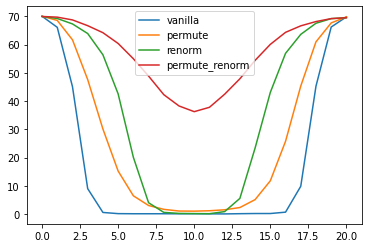

In [22]:
for k in stats.keys():
    cc = [b[2] for b in stats[k]]
    plt.plot(cc, label=k)
plt.legend()
plt.show()